In [1]:
#@title
import numpy as np
#from scipy import optimize
#from scipy.misc import derivative
import matplotlib.pyplot as plt
#import pickle 
from sklearn.preprocessing import normalize


#from shapely.geometry import LineString
#from shapely.geometry import Point

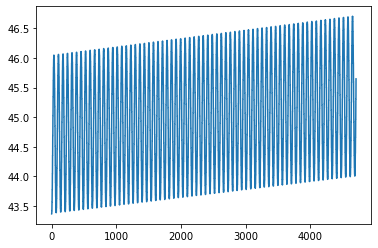

In [4]:
#slit position
def slit(t, s, omega):
    return -h-s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))


def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    m = (vel_vec[1]/vel_vec[0])
    k = 0
    #print('entered enclosure:', 'x:', x, 'y:', y, 'u:', u, 'v:', v)
    while True:
        
        a = 1+ (m**2)
        b = -2*((m**2)*x - (m*(y-h)))
        c = ((m*x)**2) - (r**2) + ((y-h)**2) - (2*m*x*(y-h))
        disc = (b**2) - (4*a*c) 
        #y = sem_func(x, r)
        #print('x:', x, 'y:', y)
        #print('disc:', (b**2) - (4*a*c) )

        if disc > 0:
            sol1 = (-b-np.sqrt(disc))/(2*a) 
            sol2 = (-b+np.sqrt(disc))/(2*a)
            ysol1 = m*(sol1-x) + y
            ysol2 = m*(sol2-x) + y
            #print('sol1:', sol1, 'sol2:', sol2)
            #print('ysol1:', ysol1, 'ysol2:' ,ysol2)
            if (ysol1>h) != (ysol2>h):
                if k ==0:
                    #print('first collision')
                    if (ysol1>h):
                        xf = sol1
                        yf = ysol1
                    else:
                        xf = sol2
                        yf = ysol2
                else:
                    #print('last collision')
                    yf = h
                    xf = x + ((h-y)/m)
                    ty = (yf-y)/vel_vec[1]
                    tx = (xf-x)/vel_vec[0]
                    if tx - ty > 0.000001:
                        print('failed!: tx', tx, 'ty', ty)
                    t+=ty
                    #print('exit enclosure:', 'x:', xf, 'y:', yf, 'u:', vel_vec[0], 'v:', vel_vec[1])
                    return (xf, yf, vel_vec[0], vel_vec[1], t)
            elif ((ysol1>h) and (ysol2>h)) and k>0:
                if (x - sol1) < 0.000001:
                    xf = sol2
                    yf = ysol2
                else:
                    xf = sol1
                    yf = ysol1
                    
            else:
                print('2 y neg:' ,'ys:', ysol1, ysol2, 'xs', sol1, sol2)
        else:
            
            print('disc_neg')
        
        p = float(d_sem_func(xf, r))
        #print('p:', p)
        if p != 0:
            nor_vec = np.array([-np.sign(p), -np.sign(p)*(1/p)])
            #print('nor vec:', nor_vec)
            nor_vec = normalize(nor_vec.reshape(2, 1))
        else:
            nor_vec = np.array([0, -1]).reshape(2, 1)
        #nor_inc = normalize(vel_vec)
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        #print('ref:', ref, 'ref shape:', ref.shape)
        if np.linalg.norm(vel_vec) - np.linalg.norm(ref)>1e-5:
            print('unnormalized collision:', np.linalg.norm(vel_vec), np.linalg.norm(ref))
        tx = (xf-x)/vel_vec[0]
        ty = (yf-y)/vel_vec[1]
        if tx - ty > 0.0000001:
            print('failed!: tx', tx, 'ty', ty)
        t+=tx
        x = xf
        y = yf
        vel_vec = np.array(ref)
        k += 1
        m = ref[1]/ref[0]
        #print('x:', x, 'y:', y, 'vel_vec:', vel_vec, 'm:', m)
        


#mapping function from one state to the next  
def stadium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 
    #       't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 1e8
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        sign = np.sign(yf)
        if abs(yf)>h:
            y_left = abs(yf - (sign*h))
            quo = y_left//(2*h)
            rem = y_left%(2*h)
            if quo%2 == 1:
                yf = sign*(rem-h)
            elif quo%2 == 0:
                yf = sign*(h-rem)
                vf = -v
        if abs(yf)>h:
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            #print('next wall: semi-circle enclosure')
            (xf, yf , uf, vf, tf) = semicircle_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            #print('bottom bar')
            tf1 = tf - (2*s/v)
            tf2 = tf + (2*s/v)
            xf1 = x + u*time_step[di]
            if (coll(tf1, y, v, t, s, omega)*coll(tf2, y, v, t, s, omega))<0:
                root = rtsafe(i, tf+(np.pi/omega),y, v, t, s, omega, xacc=0.0000001, maxit = 100)
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v
                y_coll = slit(root ,s , omega)
                tf2 = root + ((-h-y_coll)/vf)
                xf = xf1 + u*(tf2-root)
                uf = u
                sign = np.sign(xf)
                if abs(xf)>l:
                    x_left = abs(xf - (sign*l))
                    quo = x_left//(2*l)
                    rem = x_left%(2*l)
                    if quo%2 == 1:
                        xf = sign*(rem-l)
                    elif quo%2 == 0:
                        xf = sign*(l-rem)
                        uf = -u
                yf = -h
                
                
            else:
                print('root out of bounds')
            
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = stadium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    #xs = []
    #ys = []
    es = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        es.append((v**2)+(u**2))
        #xs.append(x)
        #ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, es)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1


res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


    


    


In [5]:
def save_ensemble_states(ui= ((4*lam*omega)/np.sqrt(5)),
                vi=(41*((4*lam*omega)/np.sqrt(5))), 
                omega=(2*np.pi/70), 
                lam=1, l=2, h=1,s = 0.1,  ni=10000, 
                ensemble_size = 100):
    k = 0
    systems = []
    while k<ensemble_size:
        res = iteration(xi = np.random.uniform(-l,l), 
                        yi= np.random.uniform(-h,h),
                        ui= ui,
                vi=vi, omega=omega, 
                lam=lam, l=l, h=h,s = s,  ni=ni)
        systems.append(res)
        k+=1
        print(k)
    return systems
      
    # source, destination 
                   
    
omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1



systems = save_ensemble_states(ui= ui,
                vi=vi, 
                omega=omega, 
                lam=lam, l=l, h=h,s = s, ni=100000)
#np.save('stadium_100.npy', systems)   

print('saved!!')

1


KeyboardInterrupt: 

In [ ]:
tfs = []
for i in systems:
    last_state = i[len(i)-1]
    print(last_state)
    (x, y, u, v, tm) = last_state
    tfs.append(tm)

tf = min(tfs)
print(tf)

In [ ]:
def load_and_plot(time_step=1):
    t = 1
    vels = []
    ts = []
    while t<tf:
        v = 0
        for i in systems:
            for n, j in enumerate(i[0:(len(i)-1)]):
                #print(i,j)
                (x1, y1, u1, v1, t1) = j
                (x2, y2, u2, v2, t2) = i[n+1]
                if t<=t2 and t>=t1:
                    v += ((u1)**2+(v1)**2)
                    break
        vels.append(v)
        ts.append(t)
        t += time_step
        print(t)
        #print(v)
    print(vels)
    print(ts)
    
    plt.plot(ts, vels)
    plt.show()
   
        

load_and_plot(time_step=100)